# Building ProteomeTools based on a complete synthetic human proteome
https://www.nature.com/articles/nmeth.4153

"Here we report the generation and multimodal liquid chromatography–tandem mass spectrometry analysis of >330,000 synthetic tryptic peptides representing essentially all canonical human gene products"

Instead of running a digest of a protein extract, as is usual in proteomics, here the authors directly synthesized peptides and sequenced them via LC-MS-MS.

Subsequently they have measured ~1mil peptides total, including non-tryptic peptides. However this initial round is already provided in a format conducive to machine learning.

Each peptide is represented with multiple views: the experiment is rerun at six different fragmentation energies, and some peptides are detected with multiple protonation states. Carbamidomethylation of cysteine and oxidation of methionine are also present as PTMs.

In [1]:
# wget https://www.proteomicsdb.org/prosit/api/libraries.xsjs?file=FTMS_HCD_20_annotated_2019-11-12.zip
# wget https://www.proteomicsdb.org/prosit/api/libraries.xsjs?file=FTMS_HCD_23_annotated_2019-11-12.zip
# wget https://www.proteomicsdb.org/prosit/api/libraries.xsjs?file=FTMS_HCD_25_annotated_2019-11-12.zip
# wget https://www.proteomicsdb.org/prosit/api/libraries.xsjs?file=FTMS_HCD_28_annotated_2019-11-12.zip
# wget https://www.proteomicsdb.org/prosit/api/libraries.xsjs?file=FTMS_HCD_30_annotated_2019-11-12.zip
# wget https://www.proteomicsdb.org/prosit/api/libraries.xsjs?file=FTMS_HCD_35_annotated_2019-11-12.zip
# mkdir -p ./data
# mv *.zip ./data
# cd ./data && unzip *.zip && rm *.zip

In [2]:
import pandas as pd
from collections import Counter
%config InlineBackend.figure_format = 'retina'

In [3]:
%load_ext autoreload
%autoreload 2
from src.cdhit import CDHIT

In [4]:
sequences = !cat ./data/FTMS_HCD_*_annotated_2019-11-12.msp | pcregrep -o1 "Name: ([A-Z]+)"
len(sequences)

2980009

In [5]:
# On average each peptide is viewed ~7.6 times.
sequence_counts = Counter(sequences)
len(sequence_counts)

391273

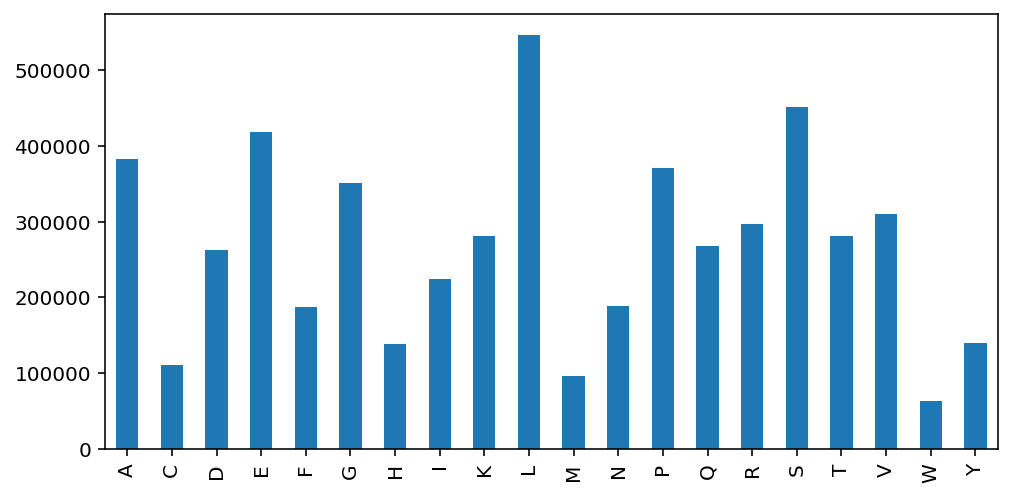

In [54]:
# Amino acid frequencies. Expect this to match human proteome + R/K overrepresentation
aa_counts = Counter(''.join(sequence_counts))
pd.Series(aa_counts).sort_index().plot(kind='bar',figsize=(8,4));

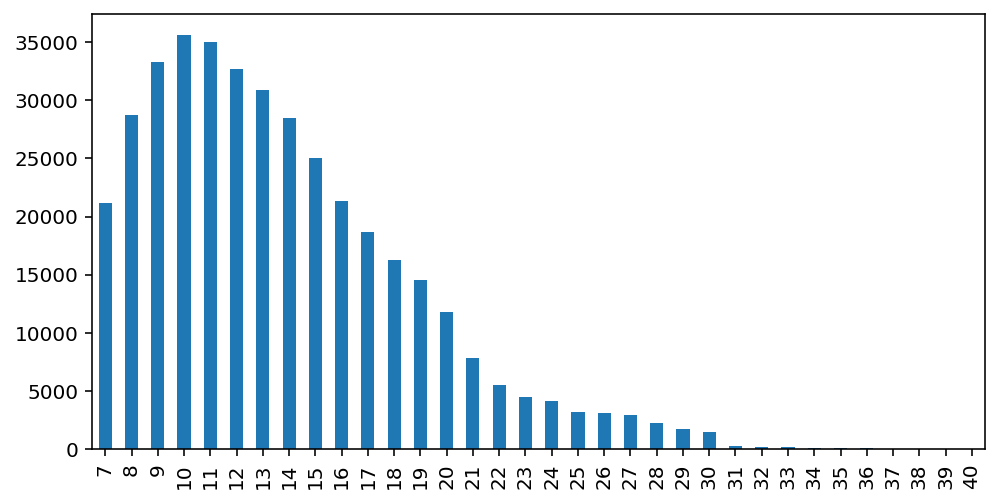

In [20]:
# Length distribution of unique sequences. Longest sequence is 40 AAs.
sequence_lengths = Counter(map(len,sequence_counts.keys()))
pd.Series(sequence_lengths).sort_index().plot(kind='bar',figsize=(8,4));

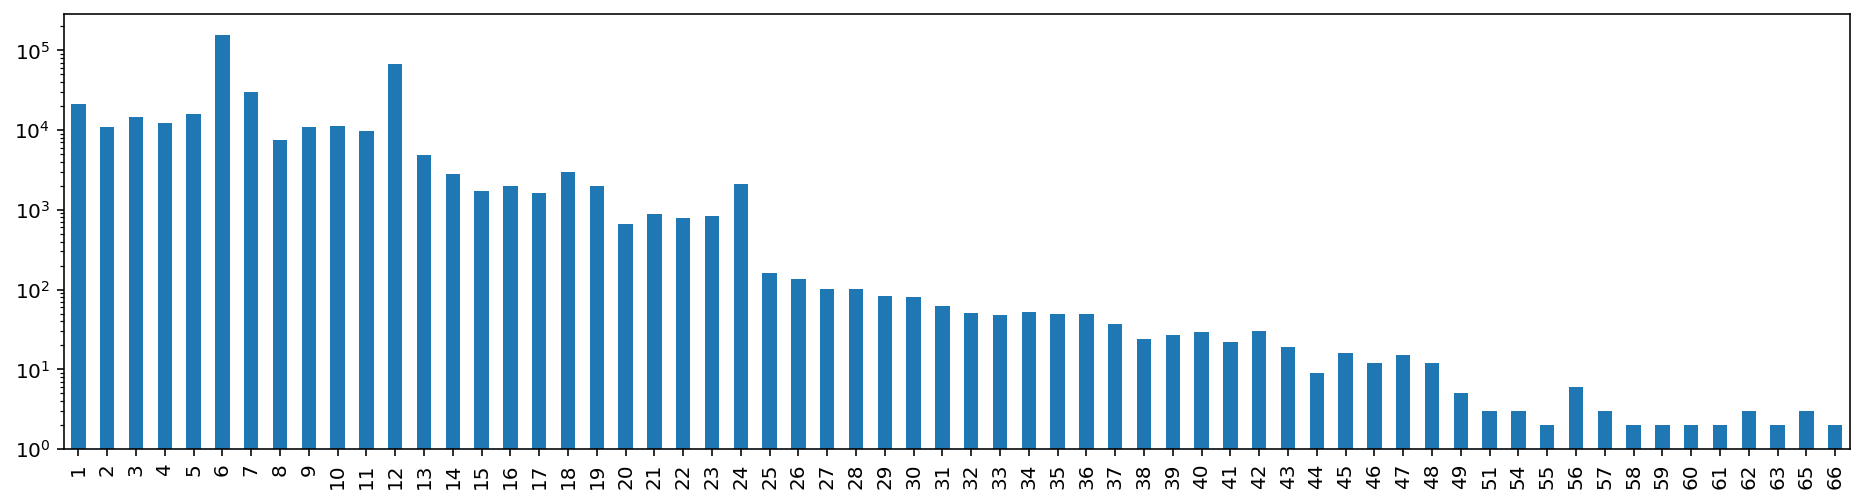

In [6]:
# Redundancy of sequences. Peak at six is expected.
# Fewer means failure to detect a sequence in some experiment. 
# 'Harmonics' at multiples of 6 arise from combinatorial protonation states and PTM sites.
# Very highly detected sequences - e.g. MEMEMEQVFEMKVK detected 66 times - are also from PTM combinatorics.
pd.Series(sequence_counts).value_counts().sort_index().plot(kind='bar',log=True,figsize=(16,4));

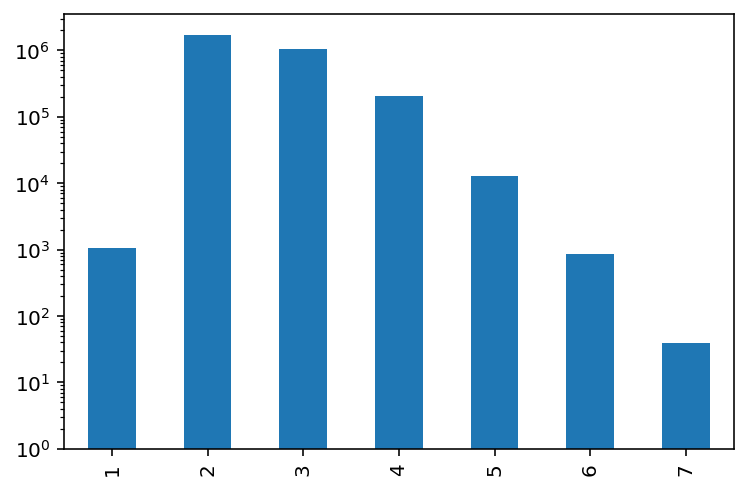

In [7]:
# Distribution of protonation states. This is typical of proteomics MS.
charges = !cat ./data/FTMS_HCD_*_annotated_2019-11-12.msp | pcregrep -o1 "Name: [A-Z]+\/(\d+)"
charge_counts = Counter(charges)
pd.Series(charge_counts).sort_index().plot(kind='bar',log=True);

In [9]:
# ~97% of sequences are tryptic (R/K at C-terminus).
tryptic_sequences = [s for s in sequence_counts if s[-1] in 'RK']
len(tryptic_sequences)

378838

In [34]:
# On average ~1.4 unique peptides per cluster @ 90% similarity threshold.
clusters_90 = CDHIT(threshold=0.9, word_length=5).fit_predict(sequence_counts)
len(set(clusters_90))

283220

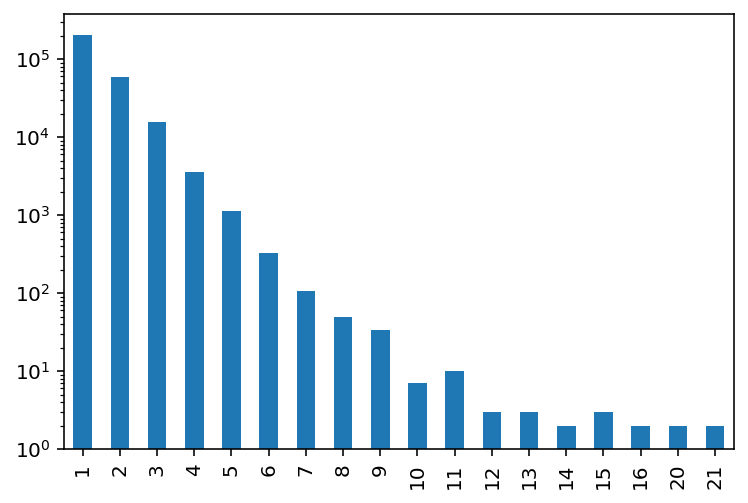

In [38]:
# Distribution of # sequences / cluster @ 90%.
pd.Series(Counter(clusters_90)).value_counts().sort_index().plot(kind='bar',log=True);

In [47]:
# (3 is largest word length compatible with 50%.)
clusters_50 = CDHIT(threshold=0.5, word_length=3).fit_predict(sequence_counts)
len(set(clusters_50))

30462

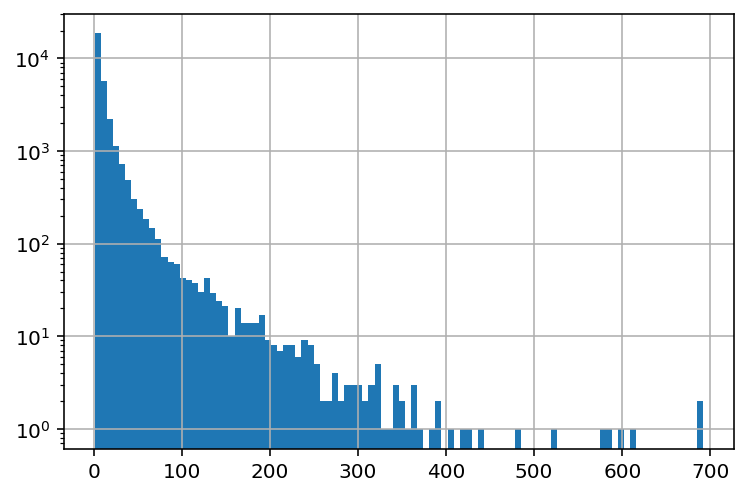

In [53]:
# Distribution of # sequences / cluster @ 50%.
pd.Series(Counter(clusters_50)).hist(bins=100,log=True);

In [ ]:
# TODO: compare ProteomeTools sequences to peptide engineering databases.
# (Meaning of above is unclear to me. Want to see overlap / diversity compared to what's already out there.)